## Packages

In [135]:
#%cd /content/drive/MyDrive/MscThesis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import umap
import pandas as pd
import time
import gwpy
import nds2 # conda config --add channels conda-forge \n conda install python-nds2-client
import numba
import h5py
from gwpy.table import EventTable
from gwpy.table import GravitySpyTable
from gwpy.detector import ChannelList, Channel
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries #if this does not work, remove h5py and reinstall h5py
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM, DER
from avalanche.logging import InteractiveLogger, TextLogger, CSVLogger
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics, \
mean_scores_metrics, topk_acc_metrics, class_accuracy_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

# log to text file
text_logger = TextLogger(open("multiview_fusion_naive_log_100epochs.txt", "a"))
# print to stdout
interactive_logger = InteractiveLogger()
csv_logger = CSVLogger()

4


In [2]:
# Set the environment variables
os.environ["GRAVITYSPY_DATABASE_USER"] = "mla"
os.environ["GRAVITYSPY_DATABASE_PASSWD"] = "gl1tch35Rb4d!"

In [3]:
current_dir = %pwd
print(current_dir)

C:\Users\Brian.Baert\Documents\GitHub\MscThesis


In [4]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
#train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
#val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
#test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

In [5]:
O3b_csv = pd.read_csv('Data/data_o3b_high_confidence.csv')

## Load in fractal data

In [136]:
FD_location = 'C:\\Users\\Brian.Baert\\FD_CL\\final_normalized_data.npy'
FD_location_reduced = 'C:\\Users\Brian.Baert\\FD_CL\\reduced_ids_50.npy'

In [137]:
fractal_matrices = np.load(FD_location)
fractal_matrices.shape

(3584, 347, 56)

Because the initial results with the "No Glitch" class where overfitting, we opt for the reduced dataset (less auxiliary channels)

In [138]:
fractal_matrices = np.load(FD_location_reduced)
fractal_matrices.shape

(2688, 50, 56)

In [139]:
fractal_matrices[0]

array([[0.57451844, 0.574585  , 0.61747295, ..., 0.8614793 ,
        0.8710429 , 0.86270547],
       [0.82187957, 0.8134645 , 0.8314725 , ..., 0.87468857,
        0.8983555 , 0.89641106],
       [0.48615664, 0.5589393 , 0.5859381 , ..., 0.81507933,
        0.76803046, 0.7939468 ],
       ...,
       [0.58207494, 0.478571  , 0.5393343 , ..., 0.7123621 ,
        0.6273871 , 0.64899284],
       [0.45105952, 0.30550978, 0.43062353, ..., 0.39758435,
        0.5520664 , 0.39632282],
       [0.40403458, 0.32956344, 0.49127063, ..., 0.8159749 ,
        0.73265237, 0.83331215]], dtype=float32)

In [140]:
#pd_fractal = pd.DataFrame(fractal_matrices.reshape(fractal_matrices.shape[0], -1))
#pd_fractal

In [141]:
no_glitch = fractal_matrices[0:895]
whistle = fractal_matrices[896:1791]
tomte = fractal_matrices[1792:2687]
scattered_light = fractal_matrices[2688:3584]

In [142]:
labels = []
#labels.extend(['No_Glitch'] * 896)
labels.extend(['Whistle'] * 896)
labels.extend(['Tomte'] * 896)
labels.extend(['Scattered_Light'] * 896)
len(labels)
labels=np.array(labels)
len(labels)

2688

## Visualization

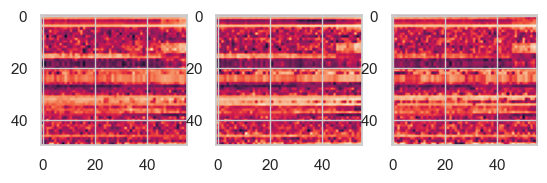

Label for fig 1 is Whistle, fig 2 is Tomte, fig 3 is Scattered_Light


In [143]:
plt.close()
fig, ax = plt.subplots(1,3)
ax[0].imshow(fractal_matrices[0])
ax[1].imshow(fractal_matrices[897])
ax[2].imshow(fractal_matrices[1793])
plt.show()
print(f'Label for fig 1 is {labels[0]}, fig 2 is {labels[897]}, fig 3 is {labels[1793]}')

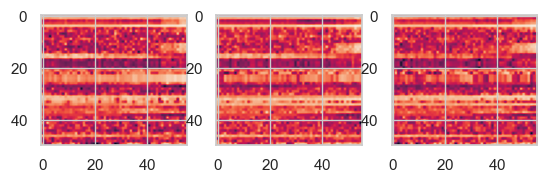

Label for fig 1 is Whistle, fig 2 is Tomte, fig 3 is Scattered_Light


In [144]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(fractal_matrices[1])
ax[1].imshow(fractal_matrices[898])
ax[2].imshow(fractal_matrices[1794])
plt.show()
print(f'Label for fig 1 is {labels[1]}, fig 2 is {labels[898]}, fig 3 is {labels[1793]}')

In [145]:
fd_mean = np.mean(fractal_matrices, axis=2)
fd_std = np.std(fractal_matrices, axis=2)
fd_max = np.max(fractal_matrices, axis=2)
fd_min = np.min(fractal_matrices, axis=2)
fd_median = np.median(fractal_matrices, axis=2)
fractal_matrices_transformed = np.stack((fd_mean, fd_median, fd_std, fd_min, fd_max), axis=2)
fractal_matrices_transformed.shape

(2688, 50, 5)

## Preprocess data

In [146]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(fractal_matrices, labels, test_size=0.2, random_state=123)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
# Verify the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (1720, 50, 56)
X_test shape: (538, 50, 56)
X_val shape: (430, 50, 56)
Y_train shape: (1720,)
Y_test shape: (538,)
Y_val shape: (430,)


In [147]:
label_mapping = {0: 'No_Glitch', 1: 'Whistle', 2: 'Tomte', 3: 'Scattered_Light'}
# Replace values using the dictionary
#classes = ['No_Glitch', 'Whistle', 'Tomte', 'Scattered_Light']
classes = ['Whistle', 'Tomte', 'Scattered_Light']
print(classes)

['Whistle', 'Tomte', 'Scattered_Light']


In [148]:
import torch
from sklearn.preprocessing import LabelEncoder
X_train = torch.from_numpy(X_train).float()  
X_test = torch.from_numpy(X_test).float()
X_val = torch.from_numpy(X_val).float()
# Create a label encoder
le = LabelEncoder()
# Fit the encoder on the training labels
le.fit(Y_train)
le.fit(Y_test)
le.fit(Y_val)
# Convert string labels to numerical labels
Y_train_encoded = le.transform(Y_train)
Y_test_encoded = le.transform(Y_test)
Y_val_encoded = le.transform(Y_val)
# Convert the encoded labels to a long tensor
Y_train_labels = torch.from_numpy(Y_train_encoded).long()
Y_test_labels = torch.from_numpy(Y_test_encoded).long()
Y_val_labels = torch.from_numpy(Y_val_encoded).long()

In [149]:
# Assuming your data and labels are loaded into 'data' and 'labels' variables
train_data = my_dataloaders.FractalDataset(X_train, Y_train_labels)
train_data_av = AvalancheDataset(train_data)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = my_dataloaders.FractalDataset(X_test, Y_test_labels)
test_data_av = AvalancheDataset(test_data)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
val_data = my_dataloaders.FractalDataset(X_val, Y_val_labels)
val_data_av = AvalancheDataset(val_data)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)         
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

FractalDimensionConvNet(
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

In [150]:
#x = torch.randn(16,21,56)
x = torch.randn(16,50,56)
output = model(x)
print(output.shape)

torch.Size([16, 3])


In [23]:
import torch.optim as optim

# Define hyperparameters
learning_rate = 0.0001 # reduce it + add early stopping
momentum=0.9
epochs = 100
patience = 4
best_loss = float('inf')
best_epoch = 0
early_stop = False

criterion = nn.MSELoss()
# Define optimizer (e.g., Adam optimizer)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-7, weight_decay=1e-5)

# Loop through epochs
for epoch in range(epochs):
    # Loop through data batches
    for data_X, labels_Y in train_loader:
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data_X)
        #print(outputs)
        predicted, _ = torch.max(outputs, 1)
        #print(predicted)
        loss = criterion(predicted, labels_Y.float())  # Convert labels to float for loss calculation

        # Backward pass and parameter update
        loss.backward()
        optimizer.step()

    #scheduler.step()
    # Print training information (optional)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Check for early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
    elif (epoch - best_epoch) >= patience:
        print(f'Early stopping at epoch {epoch+1}, best loss was {best_loss:.4f} at epoch {best_epoch+1}')
        early_stop = True
        break

if not early_stop:
    torch.save(model.state_dict(), 'Models/FD_best_model.pth')
    print('Best model saved to best_model.pth')
    print('Finished training')

Epoch [1/100], Loss: 0.8629
Epoch [2/100], Loss: 0.2456
Epoch [3/100], Loss: 0.4348
Epoch [4/100], Loss: 0.5676
Epoch [5/100], Loss: 0.1142
Epoch [6/100], Loss: 0.4036
Epoch [7/100], Loss: 0.0667
Epoch [8/100], Loss: 0.0855
Epoch [9/100], Loss: 0.1125
Epoch [10/100], Loss: 0.0389
Epoch [11/100], Loss: 0.0650
Epoch [12/100], Loss: 0.1174
Epoch [13/100], Loss: 0.0805
Epoch [14/100], Loss: 0.0090
Epoch [15/100], Loss: 0.1172
Epoch [16/100], Loss: 0.2215
Epoch [17/100], Loss: 0.1061
Epoch [18/100], Loss: 0.0957
Early stopping at epoch 18, best loss was 0.0090 at epoch 14


In [24]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 329.6234607696533 ms


In [25]:
y_pred_list

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

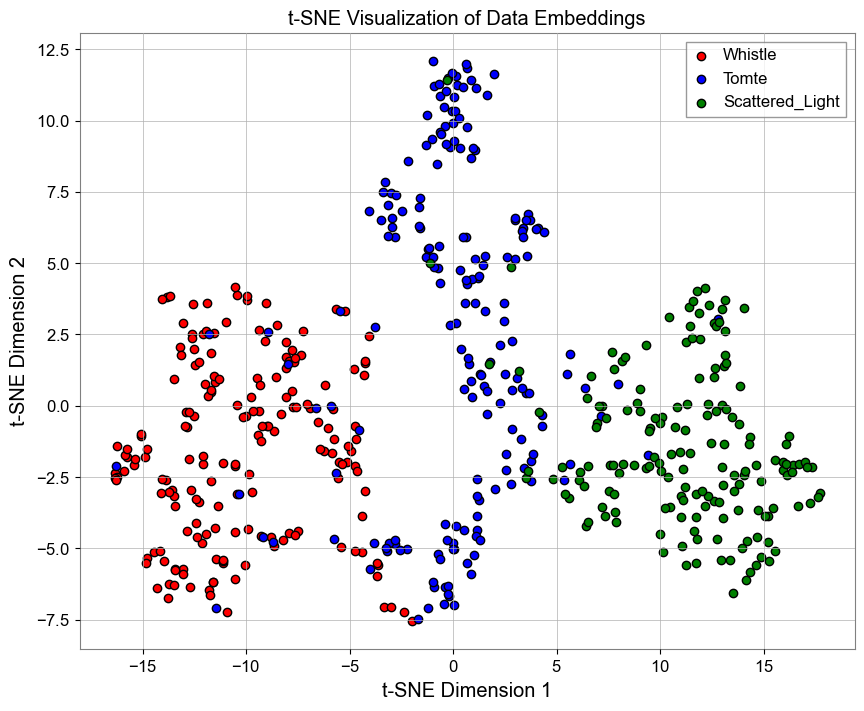

plot_tSNE_data_embedding: 1793.2441234588623 ms


In [26]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_test.png")

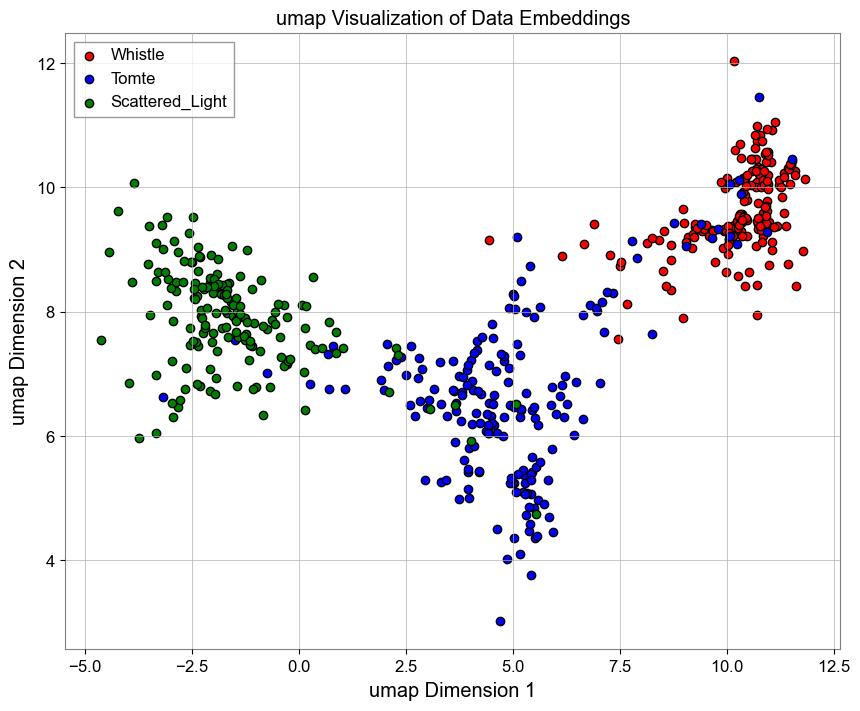

plot_umap_data_embedding: 17054.37207221985 ms


In [27]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_test.png")

In [28]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

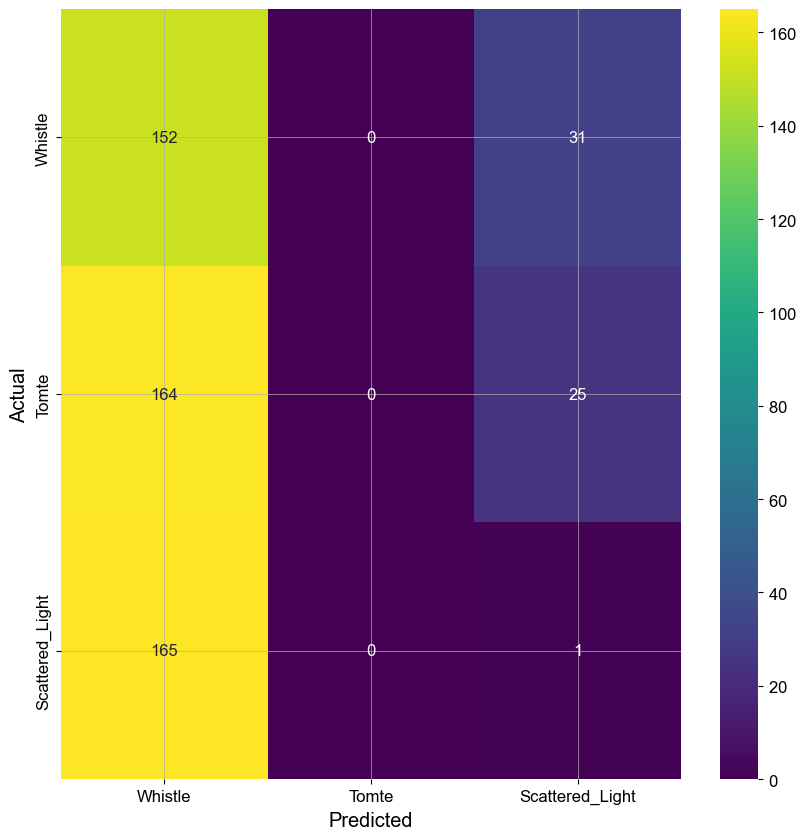

In [29]:
my_utils.plot_confusion_matrix(cm, classes, 'cm_FD_model.png')

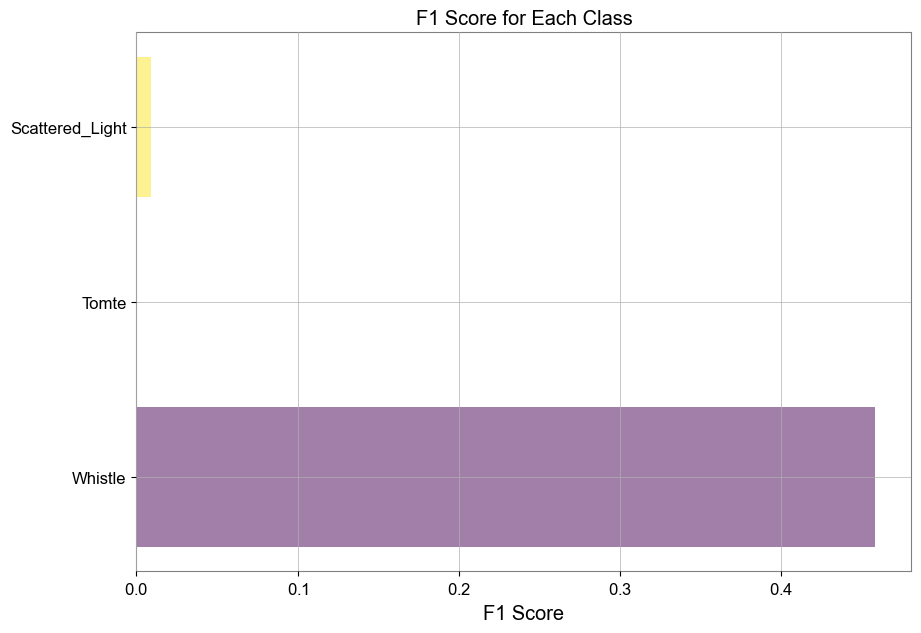

In [30]:
my_utils.plot_f1_scores(f1, classes, 'f1_FD_model.png')

## Naive Continual strategy

In [151]:
# Assuming your data and labels are loaded into 'data' and 'labels' variables
train_data = my_dataloaders.FractalDataset(X_train, Y_train_labels)
train_data_av = AvalancheDataset(train_data)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = my_dataloaders.FractalDataset(X_test, Y_test_labels)
test_data_av = AvalancheDataset(test_data)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
val_data = my_dataloaders.FractalDataset(X_val, Y_val_labels)
val_data_av = AvalancheDataset(val_data)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)         
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

FractalDimensionConvNet(
  (conv1): Conv1d(50, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

In [152]:
train_data_av.targets = [label.tolist() for i, label in enumerate(train_data.labels)]
test_data_av.targets = [label.tolist() for i, label in enumerate(test_data.labels)]
val_data_av.targets = [label.tolist() for i, label in enumerate(val_data.labels)]

In [153]:
train_data_av.uniques = list(set(train_data.labels))
test_data_av.uniques = list(set(test_data.labels))
val_data_av.uniques = list(set(val_data.labels))

In [154]:
batch = next(iter(train_data))
matrix, label = batch
print(matrix.shape)
print(label)

torch.Size([50, 56])
tensor(1)


In [155]:
bm = nc_benchmark(
    train_dataset=train_data_av,
    test_dataset=val_data_av,
    n_experiences=3,
    shuffle=True,
    seed=1234,
    task_labels=False
)

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forward_transfer_metrics(experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    mean_scores_metrics(on_train=True, on_eval=True),
    topk_acc_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

# OPTIMIZER and CRITERION
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=16, train_epochs=15, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_data)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

  6%|▌         | 2/36 [00:48<13:49, 24.40s/it]


Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.Naive object at 0x000001F63F5B9630>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 13.88it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0769
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9756
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9756
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 14.93it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 14.63it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/tr

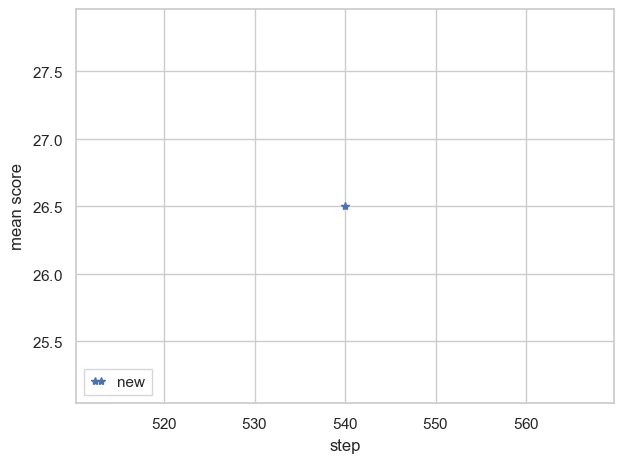

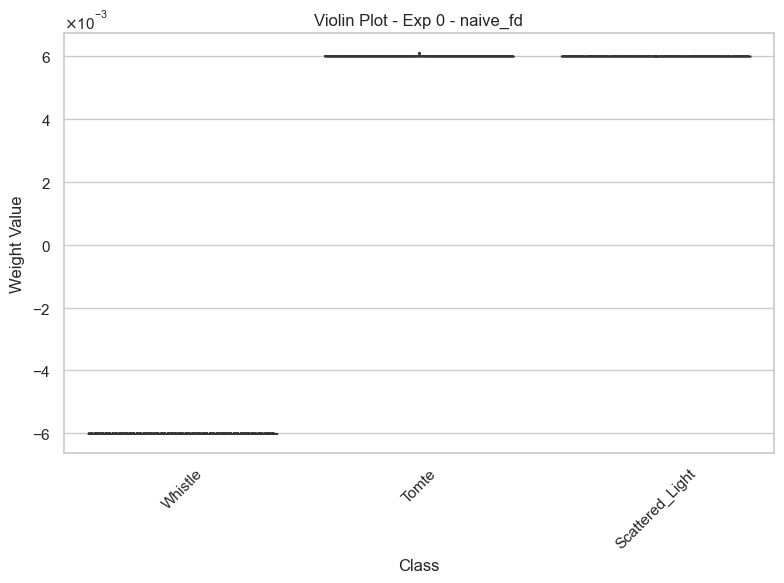

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 38/38 [00:03<00:00, 10.40it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.2907
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9066
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9140
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.8990
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:03<00:00, 11.65it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1442
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9825
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9868
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9781
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:02<00:00, 13.95it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0477
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9875
	Top1_ClassAc

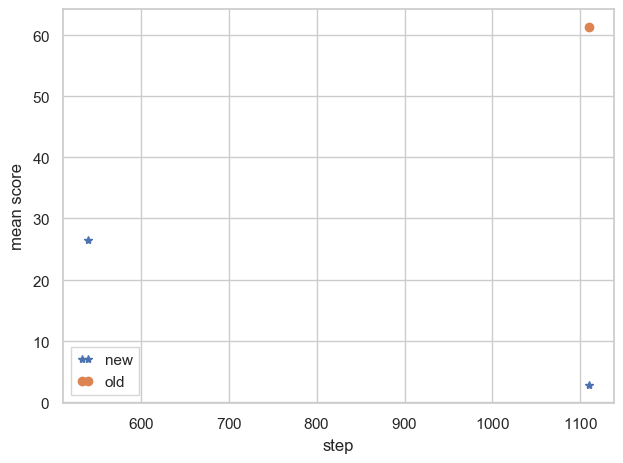

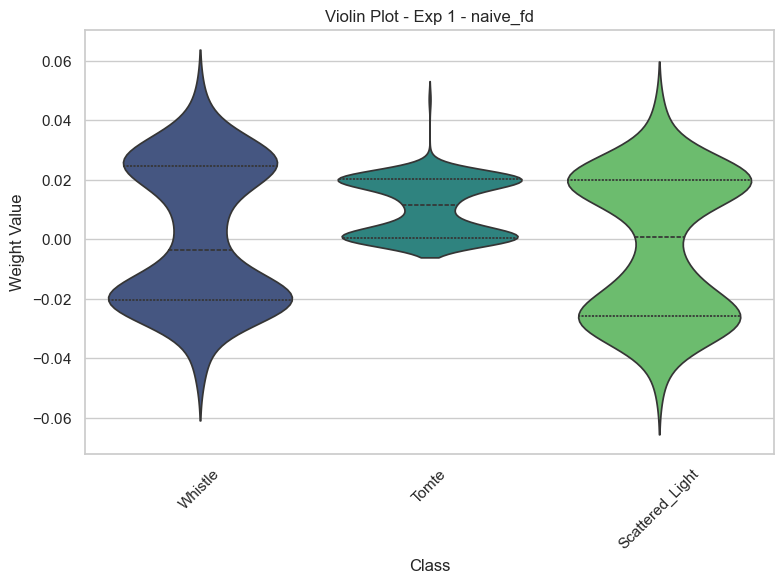

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:02<00:00, 12.49it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.9442
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6622
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.7376
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.6691
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.5719
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:02<00:00, 12.39it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4506
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8293
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.8702
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.7848
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.8758
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:02<00:00, 12.73it/s]
Epoch 2 en

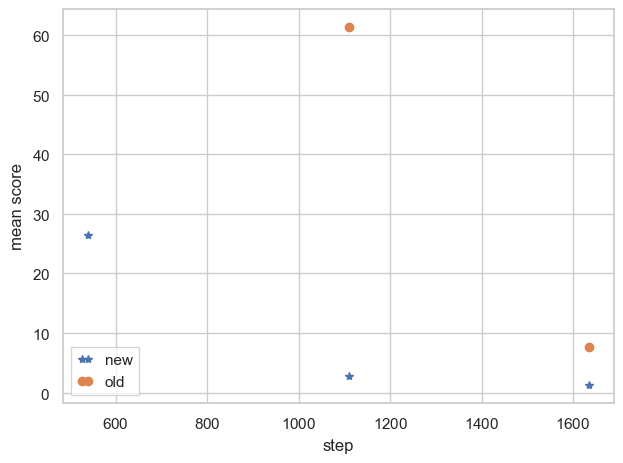

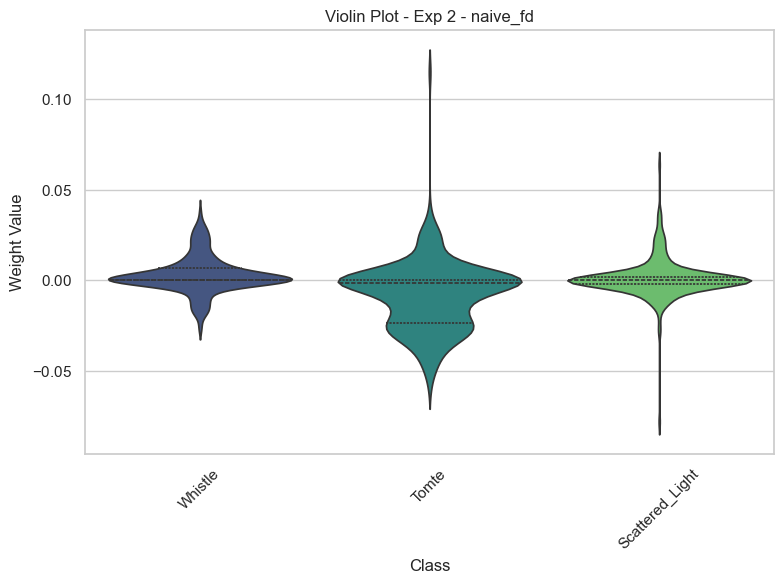

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 151874.6852874756 ms


In [114]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'naive_fd')

In [115]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 271.61574363708496 ms


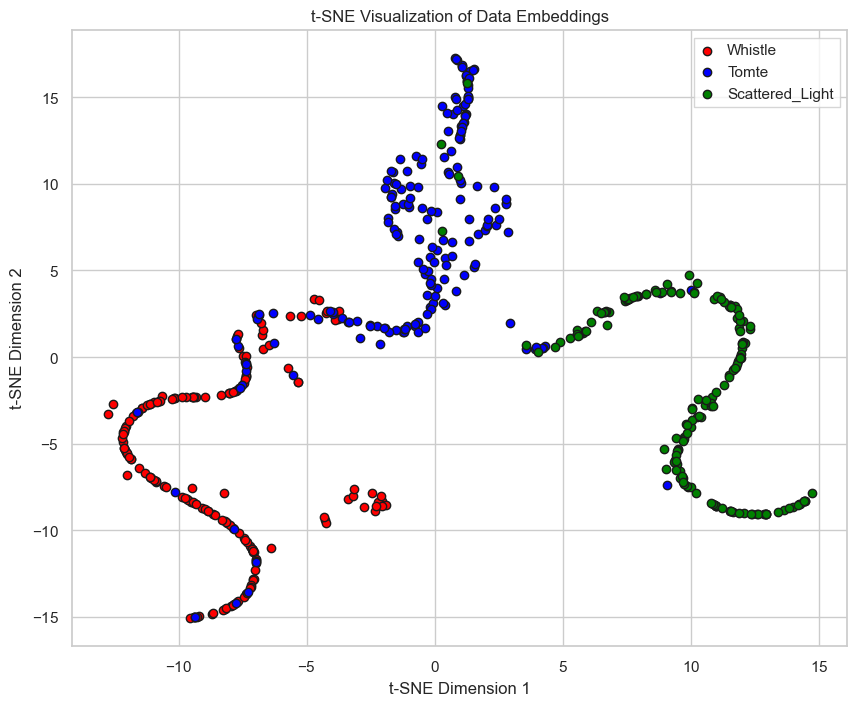

plot_tSNE_data_embedding: 1822.9494094848633 ms


In [116]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_naive_test.png")

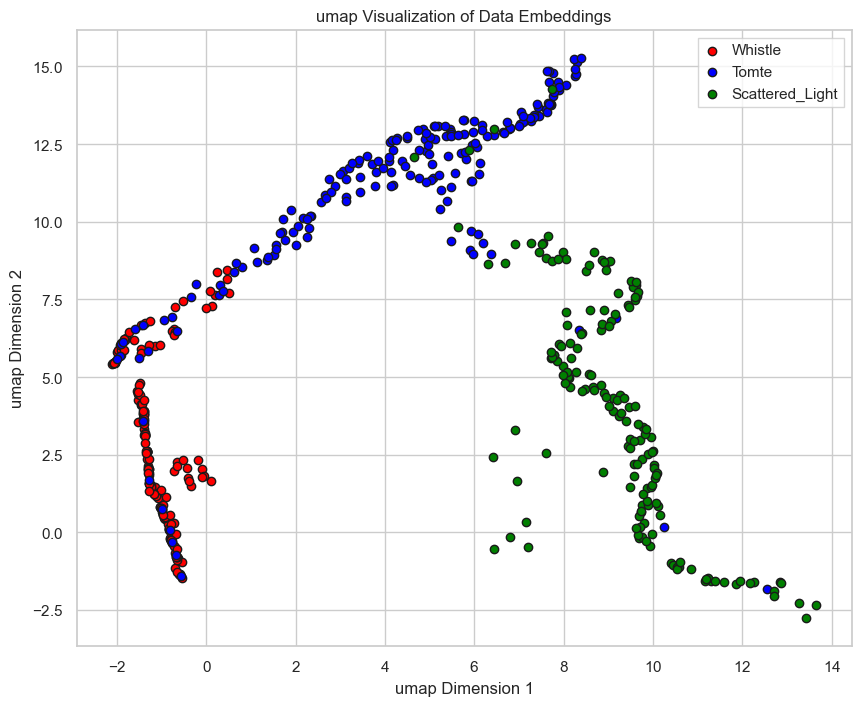

plot_umap_data_embedding: 6838.191509246826 ms


In [117]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_naive_test.png")

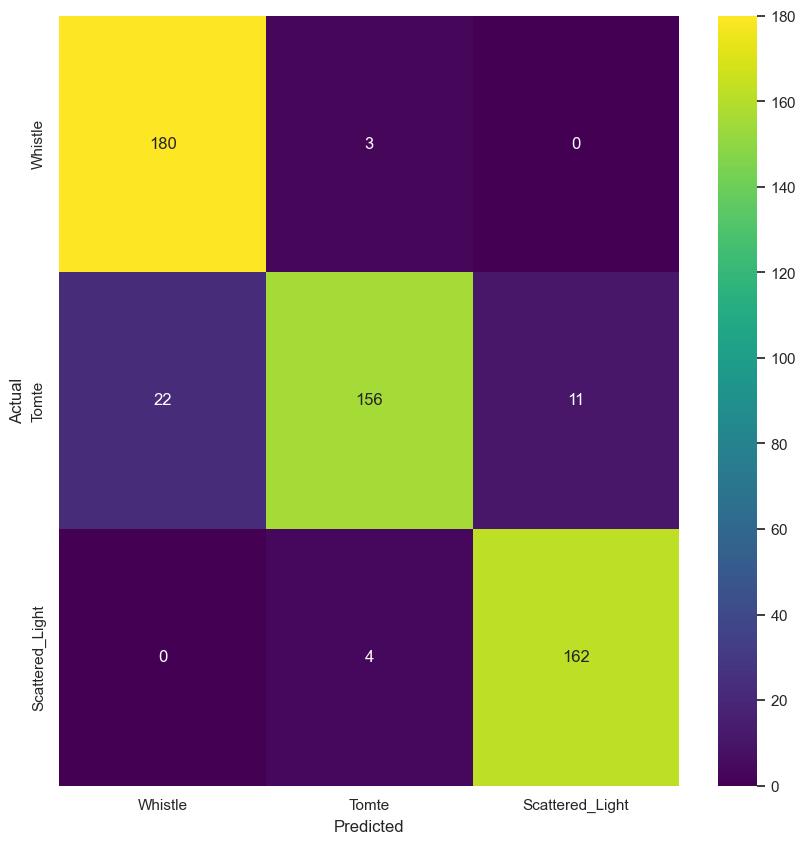

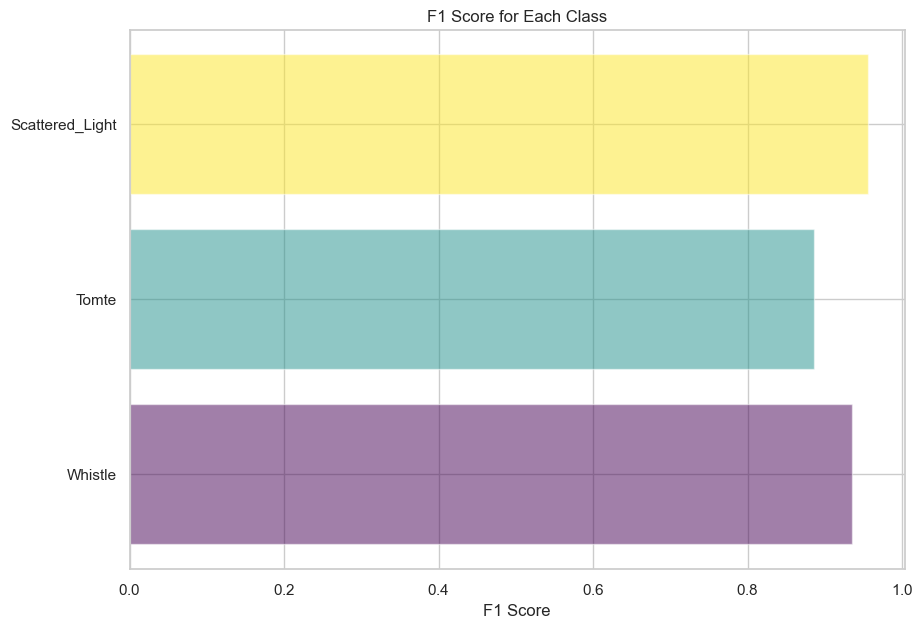

In [118]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'cm_FD_model_naive.png')
my_utils.plot_f1_scores(f1, classes, 'f1_FD_model_naive.png')

## LwF Continual strategy

In [119]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY 
# ALPHA AND TEMPERATURE are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_data))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.LwF object at 0x000001F63BE63520>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 13.43it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0933
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9738
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9738
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 13.99it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000


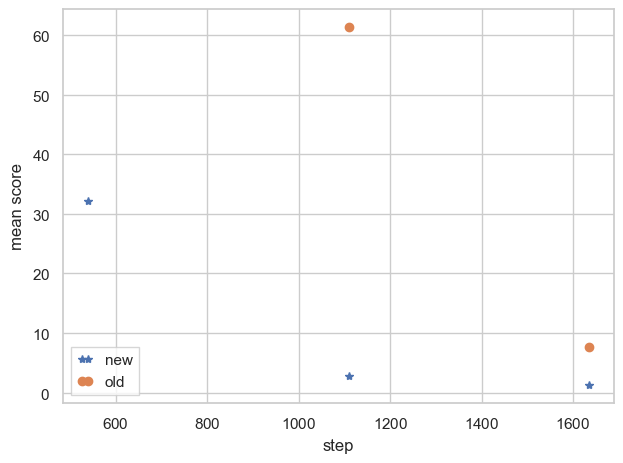

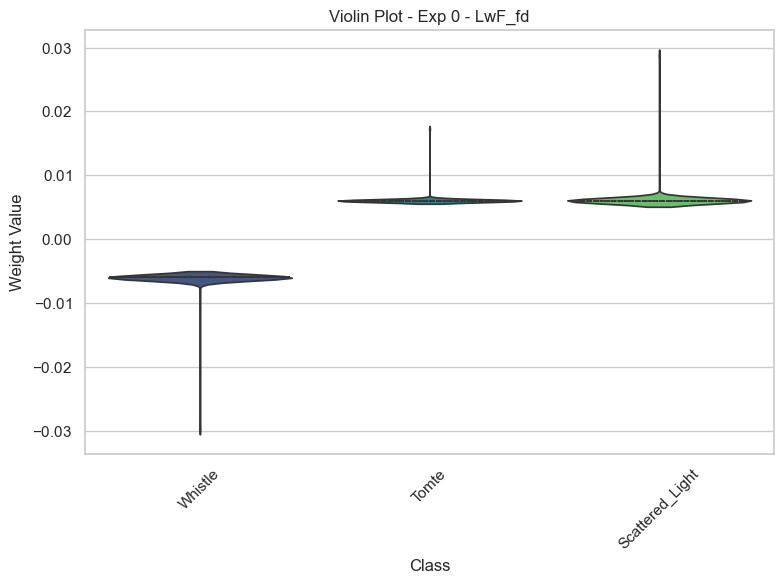

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 38/38 [00:04<00:00,  8.74it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.1797
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9049
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9074
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9024
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:04<00:00,  8.19it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7785
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9708
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9769
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9646
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:04<00:00,  8.82it/s]
Epoch 2 en

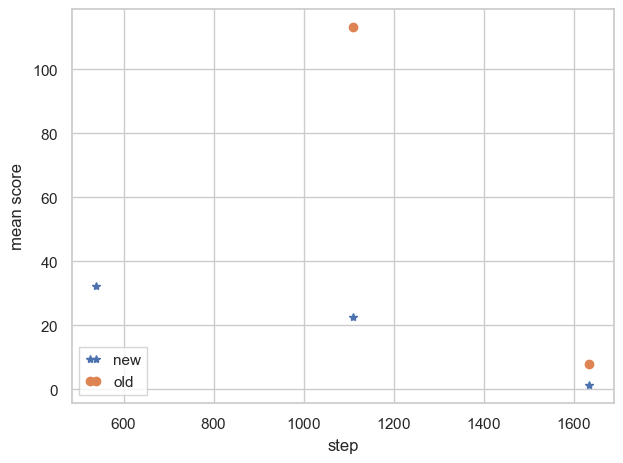

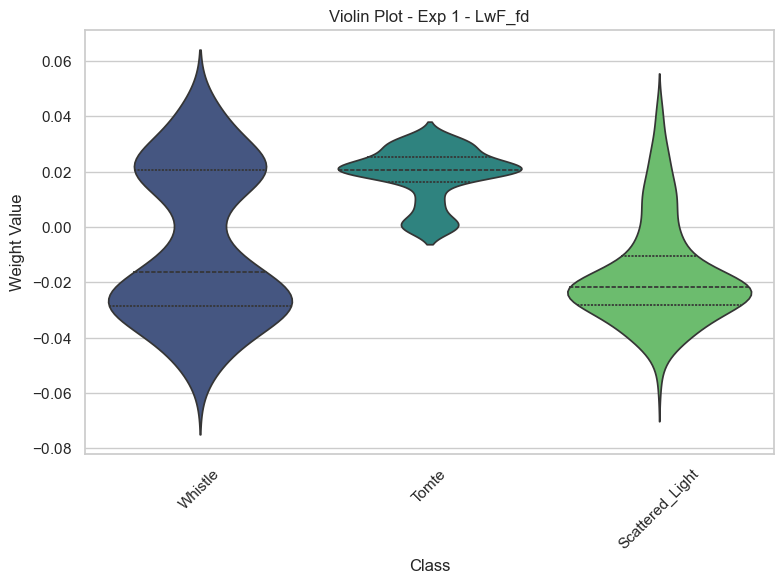

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:03<00:00, 11.40it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.9713
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4798
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.7022
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.3617
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.4965
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:03<00:00, 10.94it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9824
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6181
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9433
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.7631
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:03<00:00, 11.08it/s]
Epoch 2 en

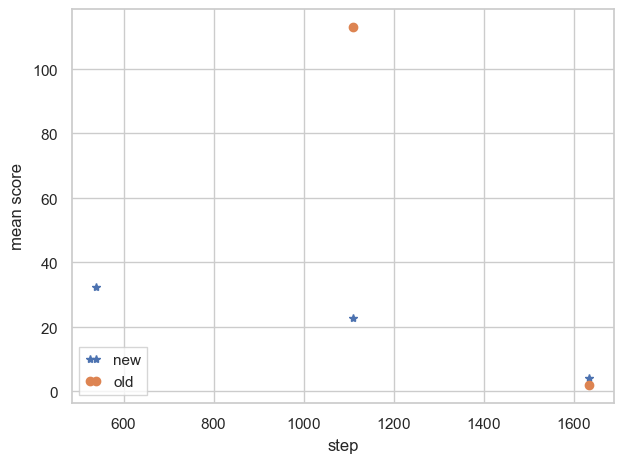

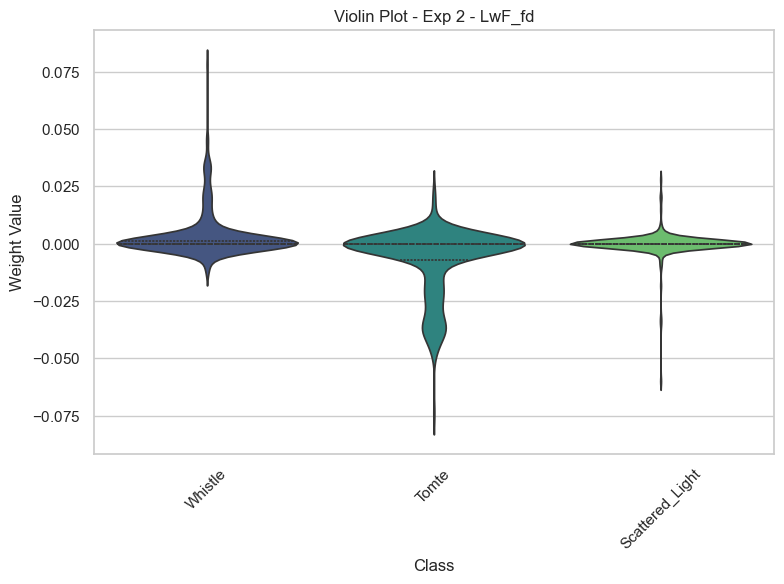

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 159629.33039665222 ms


In [120]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'LwF_fd')

In [121]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 254.1637420654297 ms


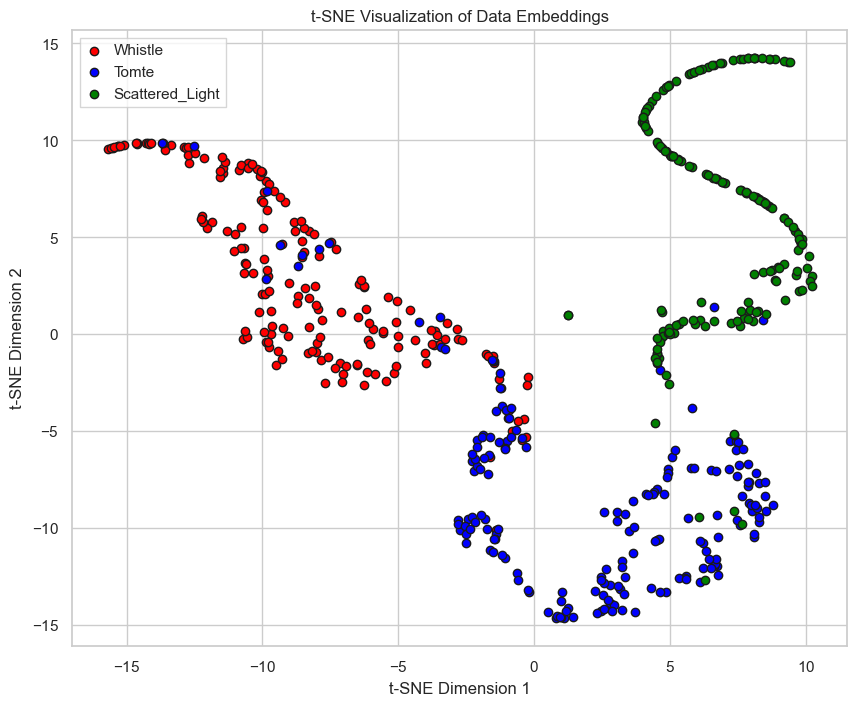

plot_tSNE_data_embedding: 1486.1857891082764 ms


In [122]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_LwF_test.png")

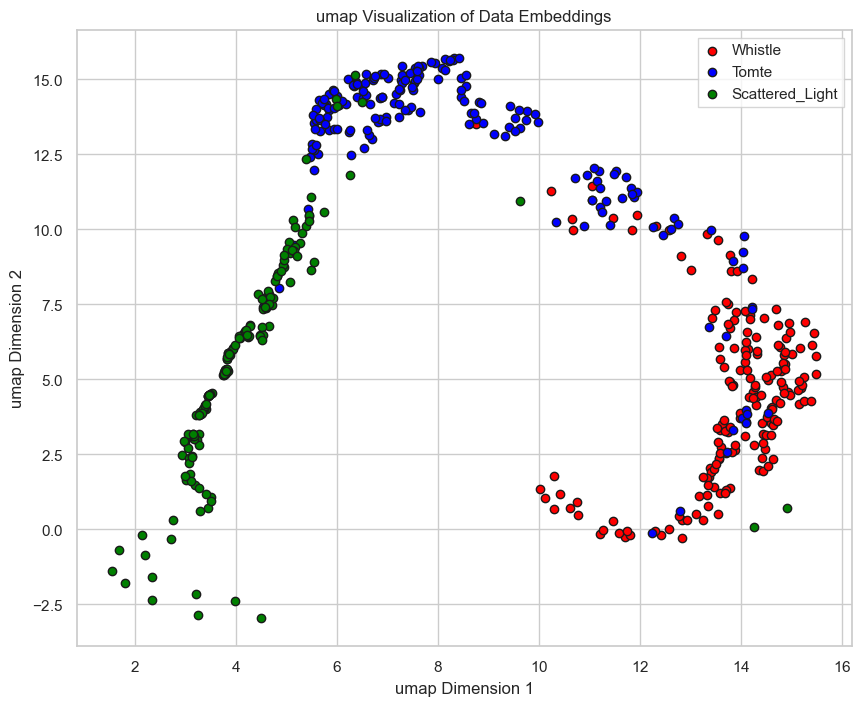

plot_umap_data_embedding: 7328.517436981201 ms


In [123]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_LwF_test.png")

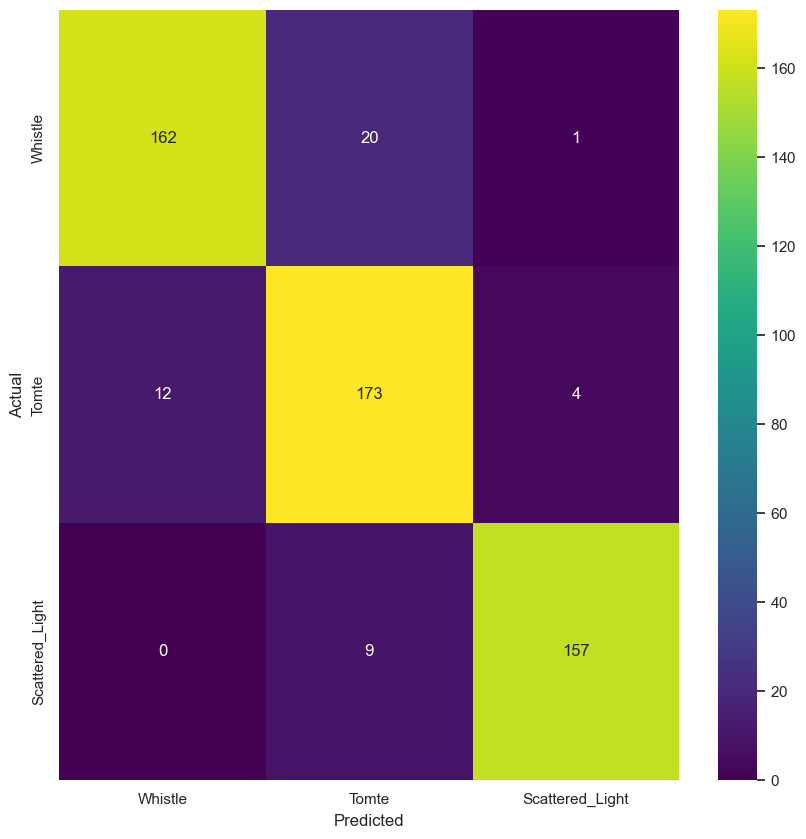

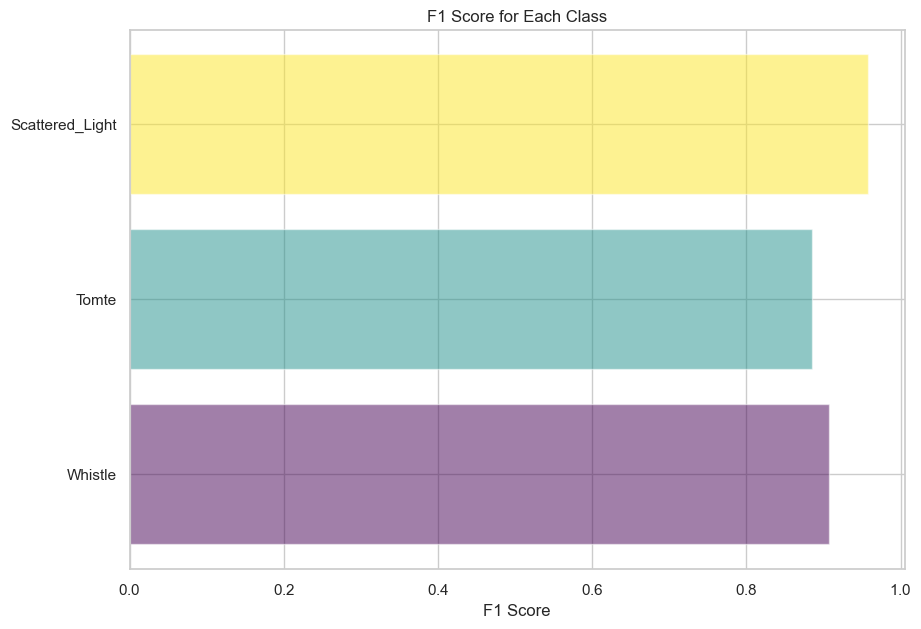

In [124]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_LwF.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_LwF.png')

## AGEM Continual Strategy

In [125]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = AGEM(
    model=model, optimizer=optimizer, criterion=criterion, patterns_per_exp=10,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_data)), AGEMPlugin(patterns_per_experience=11, sample_size=64)]
)

Starting experiment with strategy: <avalanche.training.supervised.strategy_wrappers.AGEM object at 0x000001F6306A8100>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:03<00:00, 11.75it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0469
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9808
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9808
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.44it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000

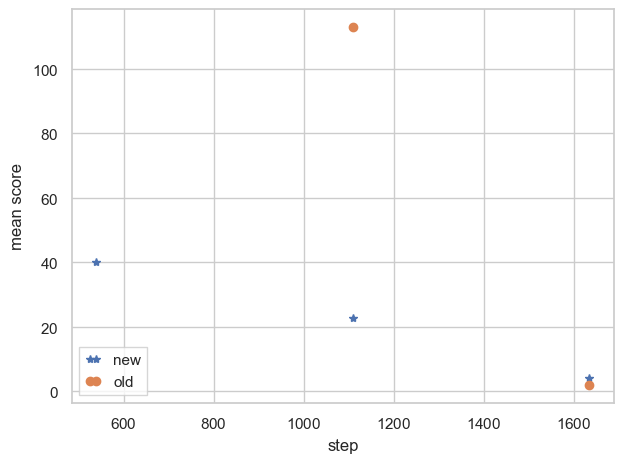

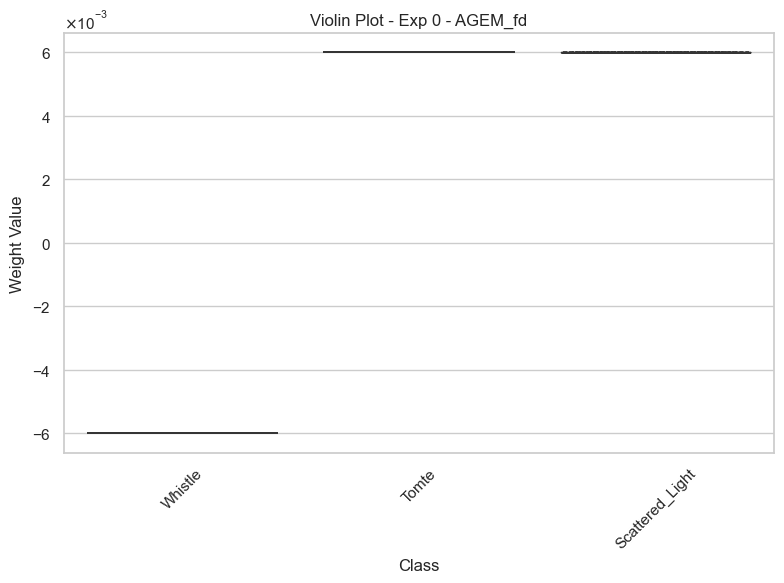

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 38/38 [00:08<00:00,  4.58it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7356
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9587
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.5084
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:06<00:00,  5.80it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5046
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 38/38 [00:06<00:00,  5.56it/s]
Epoch 2 ended.
	

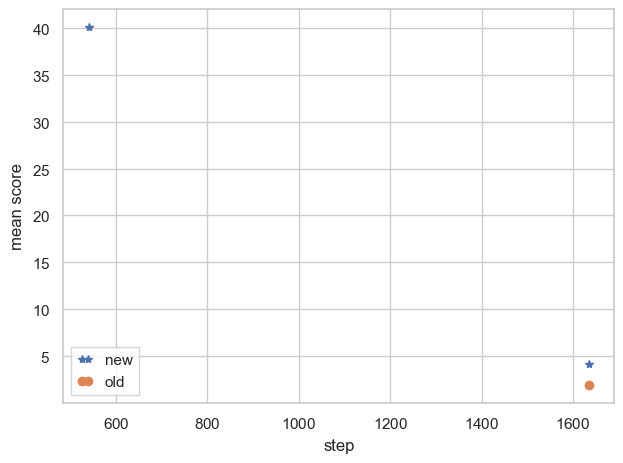

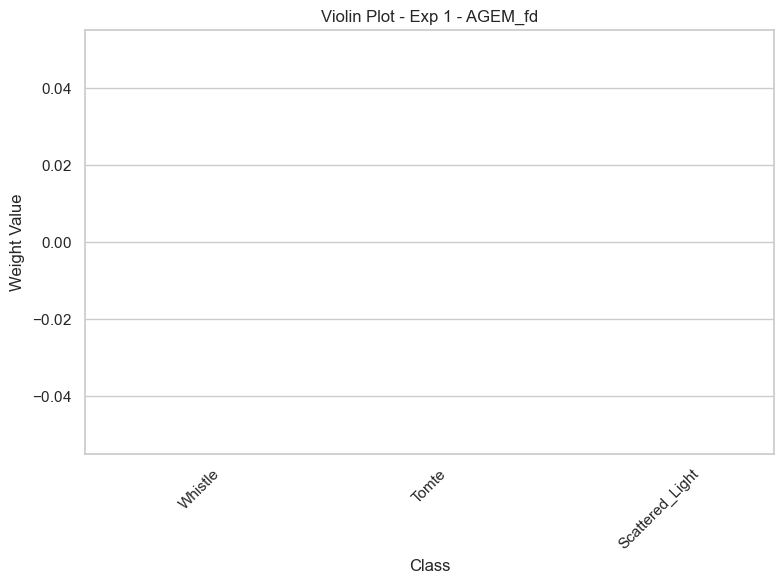

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 35/35 [00:08<00:00,  4.03it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2633
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:08<00:00,  4.14it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = nan
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2597
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 35/35 [00:07<00:00,  4.38it/s]
Epoch 2 ended.
	

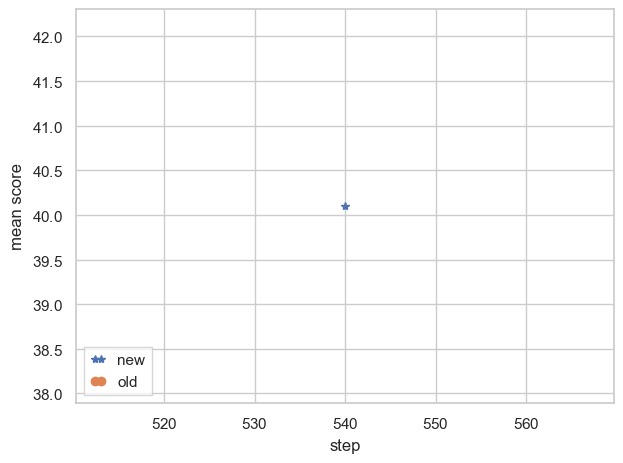

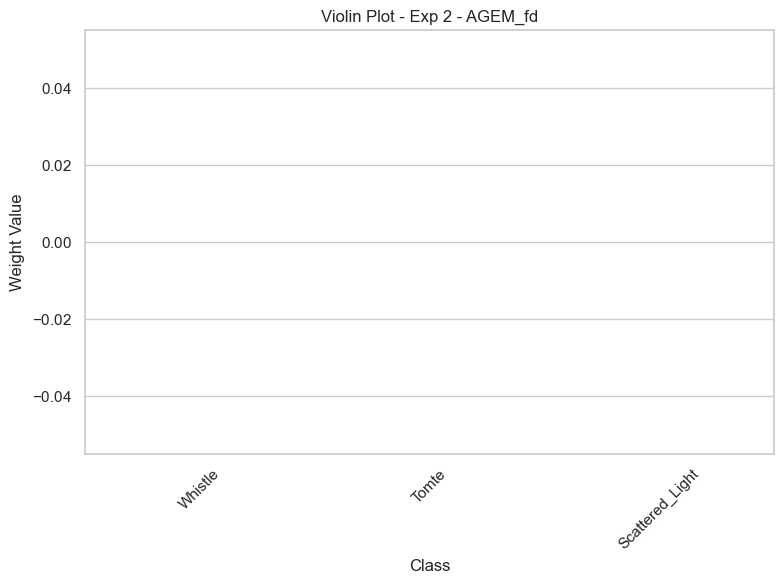

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 306666.143655777 ms


In [126]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'AGEM_fd', scr=False)

In [127]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 315.7162666320801 ms


In [128]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_AGEM_test.png")

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_AGEM_test.png")

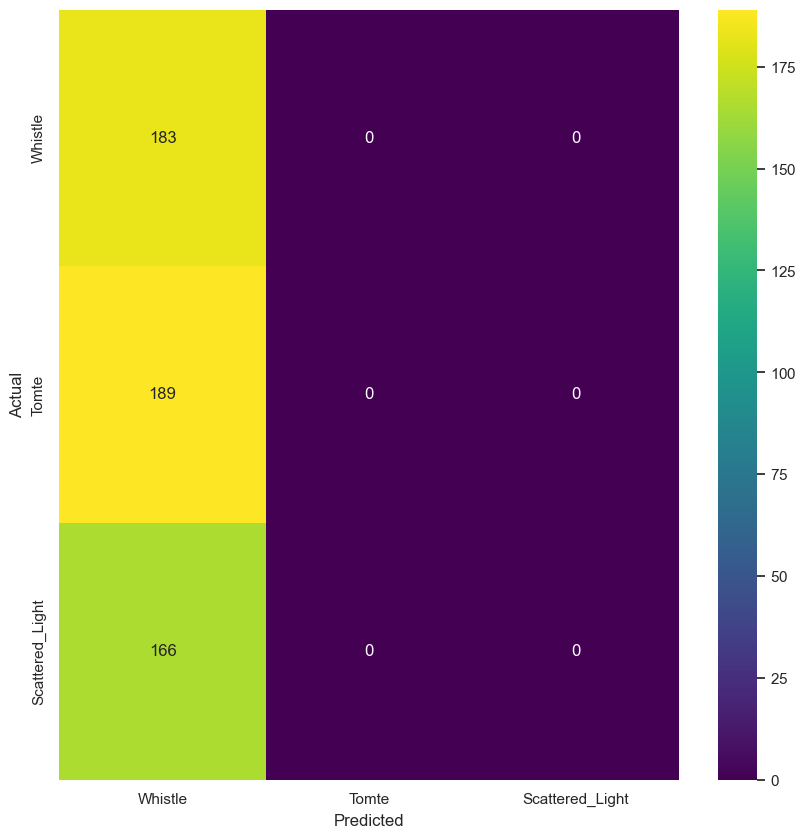

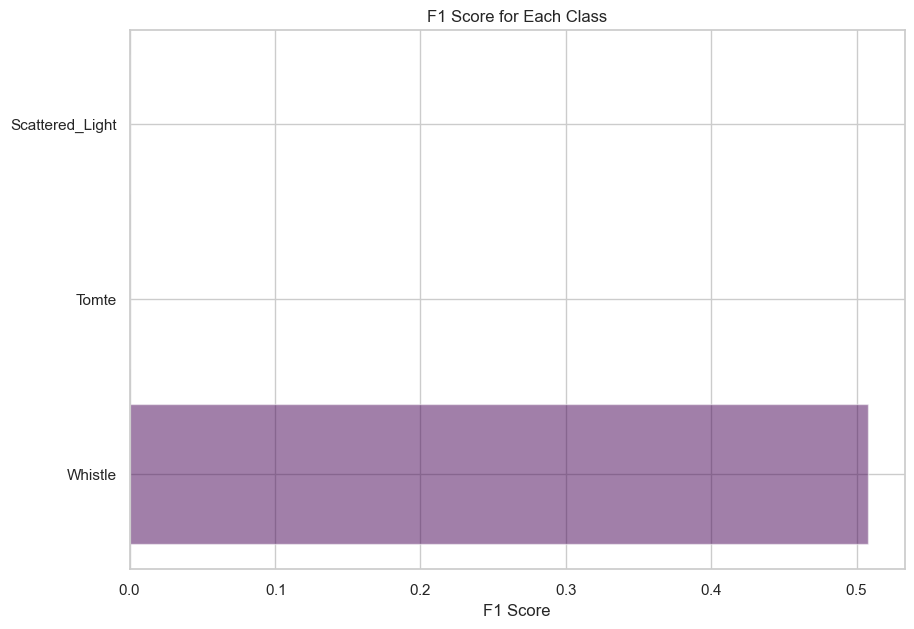

In [129]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_AGEM.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_AGEM.png')

## DER Continual Strategy

In [156]:
# Create an instance of the CNN architecture
model = my_architectures.FractalDimensionConvNet()
model.apply(my_utils.weights_init)

# STRATEGY
cl_strategy = DER(
    model=model, optimizer=optimizer, criterion=criterion, alpha=1.0, beta=0, mem_size=500,
    train_mb_size=16, train_epochs=15, eval_mb_size=16, device=device, evaluator=eval_plugin,
    #plugins=[ReplayPlugin(mem_size=2*len(train_set))]
)

Starting experiment with strategy: <avalanche.training.supervised.der.DER object at 0x000001F63F91E950>
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
100%|██████████| 37/37 [00:02<00:00, 14.48it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0550
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9725
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9725
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:02<00:00, 13.46it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 37/37 [00:02<00:00, 13.13it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_

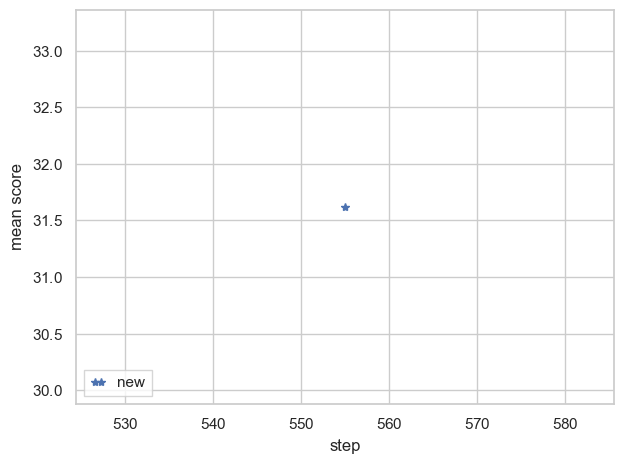

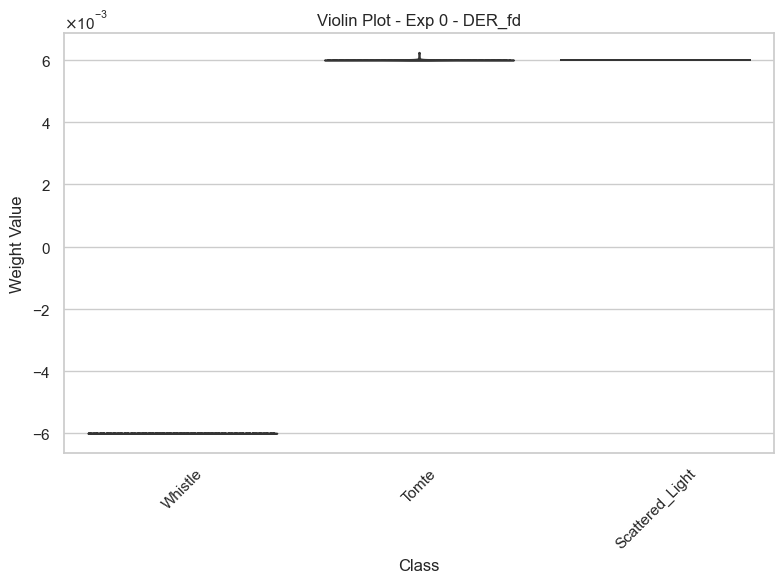

Start of experience:  1
Current Classes:  [2]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 12.67it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 132.9708
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8059
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9653
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.6457
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.26it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 11.0764
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9817
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9634
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.31it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 9.0698
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9939
	Top1_Clas

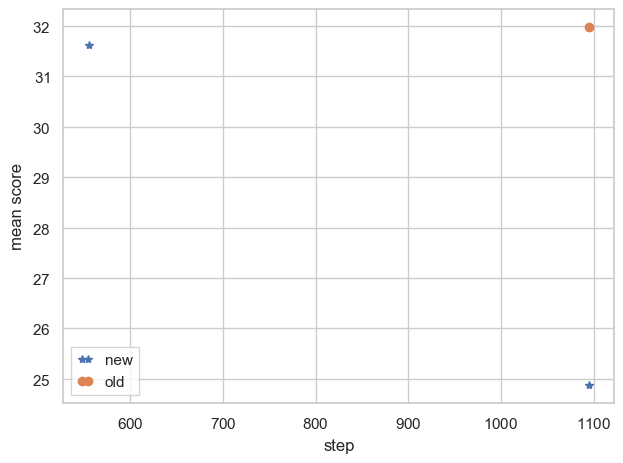

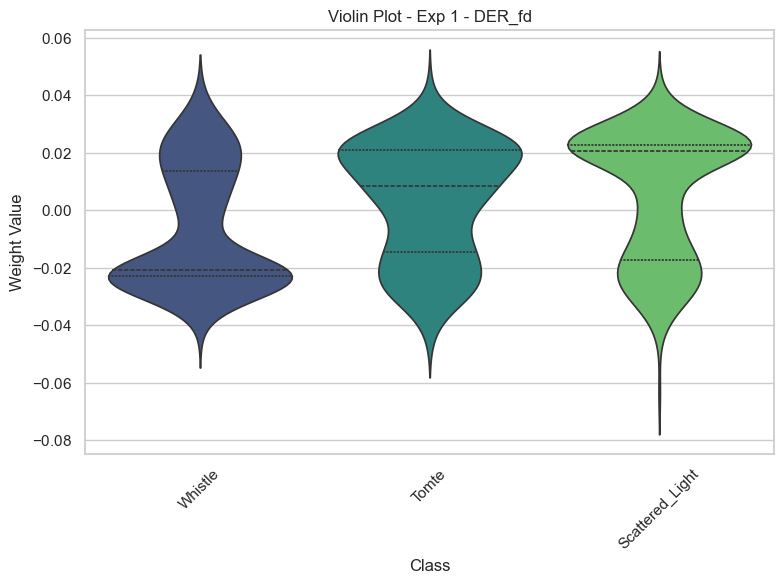

Start of experience:  2
Current Classes:  [1]
-- >> Start of training phase << --
100%|██████████| 36/36 [00:02<00:00, 12.72it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 121.4064
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5026
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 1.0000
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0106
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9720
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.80it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 104.8160
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6121
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9901
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.2314
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2 = 0.9818
	Topk_3_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 36/36 [00:02<00:00, 12.90it/s]
Epoch 

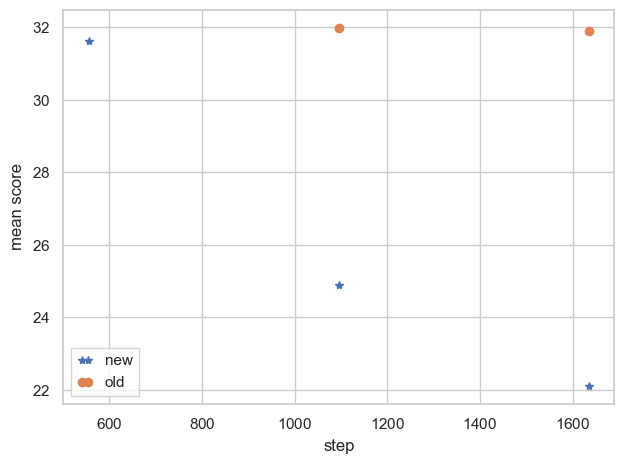

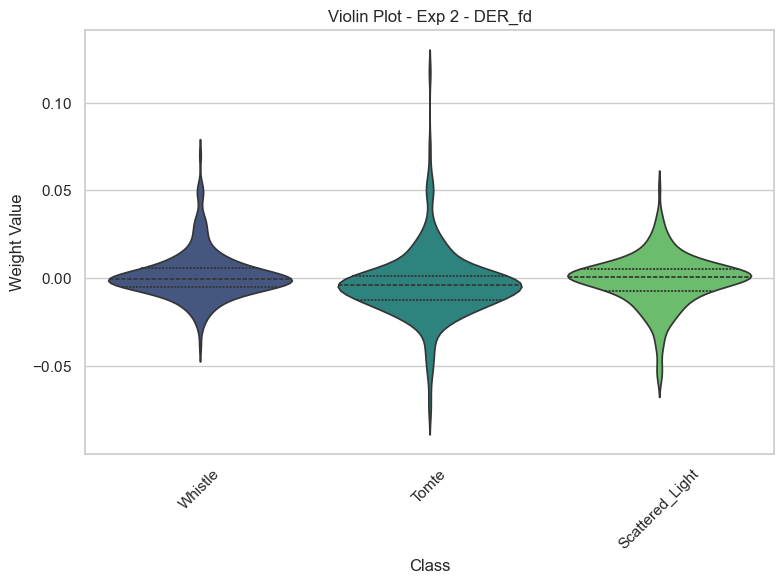

Stored metrics: ['Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0', 'Loss_Epoch/train_phase/train_stream/Task000', 'Topk_3_Acc_Epoch/train_phase/train_stream/Task000', 'MeanScores/train_phase/train_stream/new_classes', 'MeanScores/train_phase/train_stream', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2', 'MeanScores/train_phase/train_stream/old_classes', 'MeanScores/train_phase/train_stream/new_old_diff', 'Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1']
cl_simple_train_loop: 134265.95854759216 ms


In [157]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers, classes, 'DER_fd', scr=False)

In [158]:
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader)

get_predictions: 321.7923641204834 ms


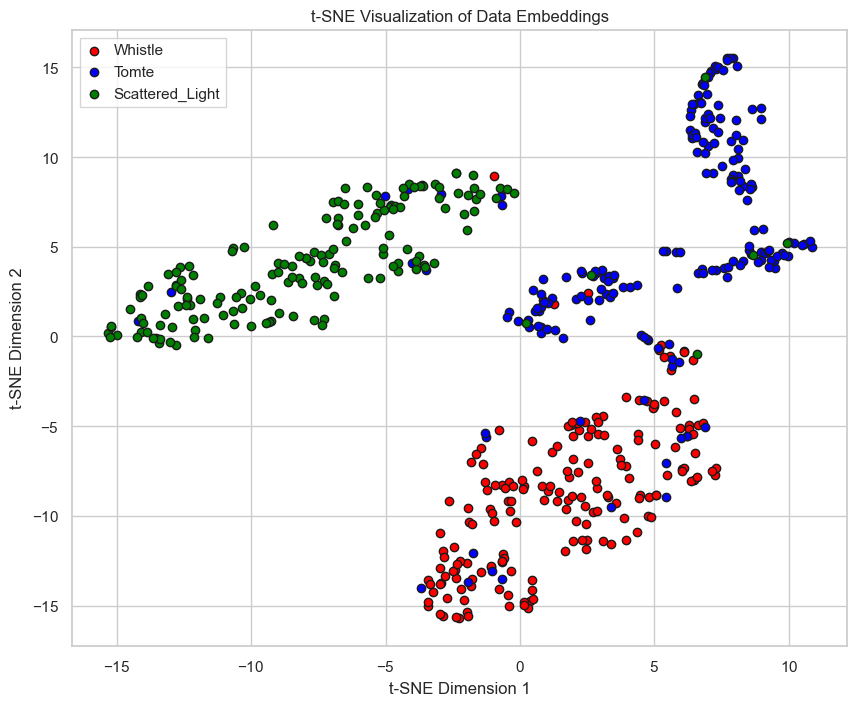

plot_tSNE_data_embedding: 1702.6560306549072 ms


In [159]:
my_utils.plot_tSNE_data_embedding(model, test_loader, classes, "Results/tSNE_FractalDimension_DER_test.png")

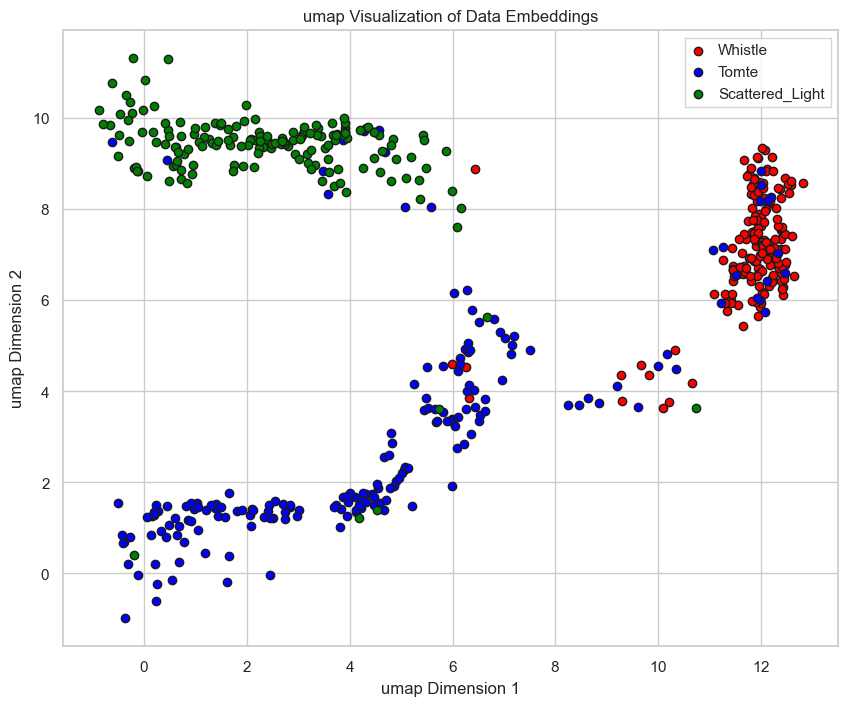

plot_umap_data_embedding: 6356.178045272827 ms


In [160]:
reducer = umap.UMAP(n_neighbors=15, metric='euclidean', n_components=2, spread=0.5, min_dist=0.2, densmap=True)
my_utils.plot_umap_data_embedding(model, test_loader, classes, reducer, "Results/umap_FractalDimension_DER_test.png")

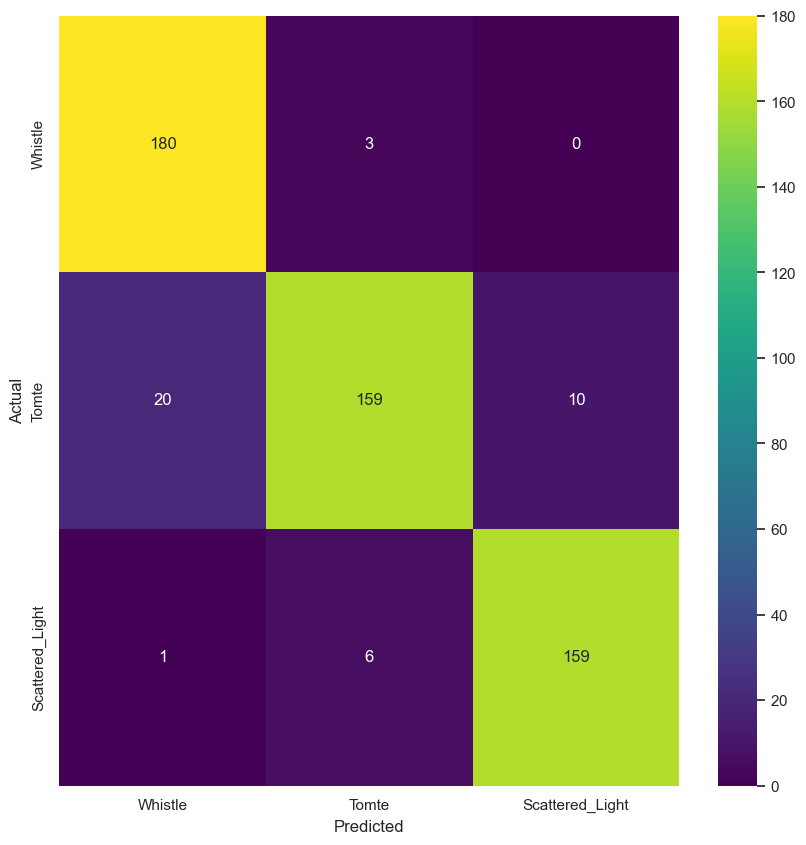

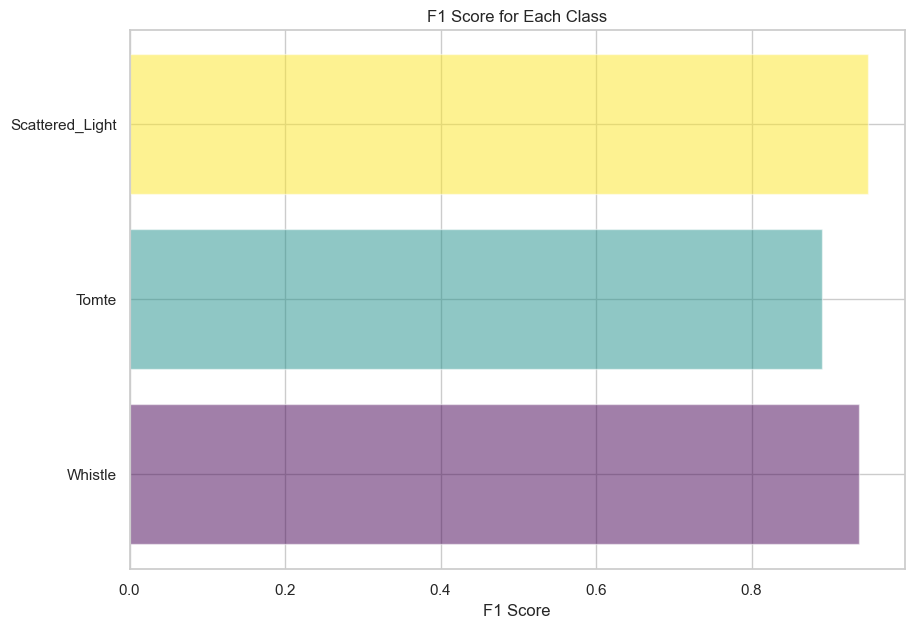

In [161]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_FD_model_DER.png')
my_utils.plot_f1_scores(f1, classes, 'Results/f1_FD_model_DER.png')